# Multimodal LLM Sample

## Azure AI Vision

[Azure AI Vision](https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/overview) offers a powerful multi-modal [embedding functionality](https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/how-to/image-retrieval). It generates numerical representations (vectors) for images, capturing their features and context and ***preserving the semantic meaning of the image***.

These vectors allow ***text-based search*** over the same vector space. By converting both images and text queries into vectors, it enables semantic matching between images and textual descriptions. Check [this](../../README.md) link for further information.

## Step 1: Install Nuget Packages & Read App Configuration


In [2]:
#r "nuget: DotNetEnv, 2.5.0"
#r "nuget: Azure.Search.Documents, 11.5.0-beta.4"
#r "nuget: Azure.Storage.Blobs, 12.19.0"
#r "nuget: System.Numerics.Tensors, 8.0.0"
#r "nuget: SkiaSharp, 2.88.3"
#r "nuget: SkiaSharp.NativeAssets.Linux.NoDependencies, 2.88.3"

#!import "SkiaUtils.cs"

using System.IO;
using DotNetEnv;

using System.Numerics.Tensors;
using Microsoft.DotNet.Interactive;
using InteractiveKernel = Microsoft.DotNet.Interactive.Kernel;

string configurationFile = "../conf/configuration.env";
Env.Load(configurationFile);

string visionApiKey = Env.GetString("AI.VISION.APIKEY");
string visionEndPoint = Env.GetString("AI.VISION.ENDPOINT");
string searchApiKey = Env.GetString("AI.SEARCH.APIKEY");
string searchEndpoint = Env.GetString("AI.SEARCH.ENDPOINT");
string storageConnectionString = Env.GetString("AI.STORAGE.CONNECTIONSTRING");

if (!File.Exists(configurationFile)) {
  Console.WriteLine("Configuration file does not exist. Pleae execute AZ CLI script provided in ../create_env/");
} else {
  Console.WriteLine("Nuget packages installed...");
  Console.WriteLine("Configuration file loaded...");
}


Installed Packages Azure.Search.Documents, 11.5.0-beta.4 Azure.Storage.Blobs, 12.19.0 DotNetEnv, 2.5.0 SkiaSharp, 2.88.3 SkiaSharp.NativeAssets.Linux.NoDependencies, 2.88.3 System.Numerics.Tensors, 8.0.0

Nuget packages installed...
Configuration file loaded...


## Step 2: Define Helper Class

The `AiVisionHelper` [class](AiVisionHelper.csx) provides simplified abstractions to:
  - Create an image embedding by crafting and executing a http call to the AI Vision REST endpoint.
  - Create an text embedding by crafting and executing a http call to the AI Vision REST endpoint.
  - Upload images to Azure Blob storage and creating a SAS
  - Create a search index in Azure AI Search
  - Store embeddings in Azure AI Search
  - Query Azure AI Search based on embedding

In [3]:
#!import "AiVisionHelper.csx"

Console.WriteLine($"Class AiVisionHelper with methods:");
Console.WriteLine($"- GetTextEmbedding(string text)");
Console.WriteLine($"- GetImageEmbedding(string imageUrl)");
Console.WriteLine($"- UploadLocalFile(string localFilePath, string containerName, string blobName)");
Console.WriteLine($"- CreateSearchIndex(string indexName)");
Console.WriteLine($"- StoreImageEmbedding(string indexName, List<ImageEmbedding> imageEmbeddings)");
Console.WriteLine($"- QuerySearchIndex(string indexName, float[] queryVector)");
Console.WriteLine($"created...");


Class AiVisionHelper with methods:
- GetTextEmbedding(string text)
- GetImageEmbedding(string imageUrl)
- UploadLocalFile(string localFilePath, string containerName, string blobName)
- CreateSearchIndex(string indexName)
- StoreImageEmbedding(string indexName, List<ImageEmbedding> imageEmbeddings)
- QuerySearchIndex(string indexName, float[] queryVector)
created...


## Step 3: Create and store image embeddings

The code cell uses the above defined `AiVisionHelper` class to:

- Create an Azure AI Search search index (`aiVisionHelper.CreateSearchIndes()`)
- Upload architecture sketches to Azure Blob storage (`aiVisionHelper.UploadLocalFile()`) and create a Shared Access Signature for the uploaded architecture sketch.
- Create image embeddings using Azure AI Vision (`aiVisionHelper.GetImageEmbedding()` by providing the previously created SAS). This will be executed in a loop for all existing architecture sketches. (Image name & image embedding are stored in a Dictionary `embeddings`)
- Store image name and image vector in Azure AI Search (`aiVisionHelper.StoreImageEmbedding()`) 

In [4]:
//Azure AI Search - Create Search Index
string searchIndexName = "vector-1717583103060";

AiVisionHelper _aiVisionHelper = new AiVisionHelper(visionApiKey, visionEndPoint, searchApiKey, searchEndpoint, storageConnectionString);
//await _aiVisionHelper.CreateSearchIndex(searchIndexName);
Console.WriteLine("Azure AI Search index created...");

Azure AI Search index created...


In [3]:
//Azure AI Search - Create Search Index
string searchIndexName = "architecture";

AiVisionHelper _aiVisionHelper = new AiVisionHelper(visionApiKey, visionEndPoint, searchApiKey, searchEndpoint, storageConnectionString);
await _aiVisionHelper.CreateSearchIndex(searchIndexName);
Console.WriteLine("Azure AI Search index created...");

//Azure AI Vision - Get Image Embedding
Dictionary<string, float[]> embeddings = new Dictionary<string, float[]>();

foreach(string fileName in Directory.GetFiles("../../media/architecture", "*.png"))
{
    Uri sasUri = await _aiVisionHelper.UploadLocalFile(fileName, "architecture", Path.GetFileName(fileName));
    embeddings.Add(fileName, await _aiVisionHelper.GetImageEmbedding(sasUri.ToString()));
}
Console.WriteLine("Azure AI Vision embeddings created...");

//Azure AI Search - Store Image Embedding
List<ImageEmbedding> imageEmbeddings = new List<ImageEmbedding>();
foreach(KeyValuePair<string, float[]> embedding in embeddings)
{
    imageEmbeddings.Add(new ImageEmbedding() {
        ImageId = Guid.NewGuid().ToString(),
        ImageDescription = embedding.Key,
        ImageVector = embedding.Value
    });
}
await _aiVisionHelper.StoreImageEmbedding(searchIndexName, imageEmbeddings);
Console.WriteLine("Azure AI Search embeddings stored...");


Azure AI Search index created...
Azure AI Vision embeddings created...
Azure AI Search embeddings stored...


## Step 4: Query Search Index

The Azure AI Search search index is queried using the search word ***Vector***. The Azure AI Vision MLLM which was used to calculate the image embeddings will be used this time to calculate a text embedding for "Vector". The helper function `aiVisionHelper.GetTextEmbedding()` is used to create the embedding. 

To query Azure AI Search the helper method `aiVisionHelper.QuerySearchIndex()` is used and the search index name which was used to store the image embeddings and the calculated text embedding are provided. 

vector:System.Single[]
Cognitive Search Results for 'lisbon dessert':
  - Honeydew-Melon_013.jpg



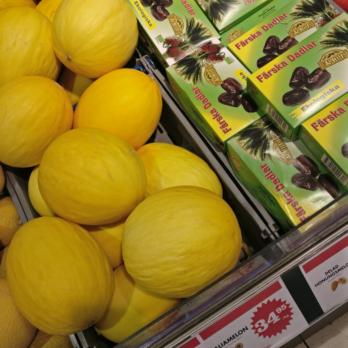

  - Lime_015.jpg



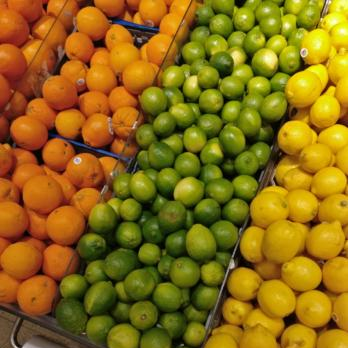

  - Passion-Fruit_011.jpg



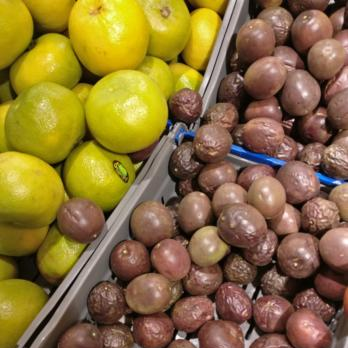

  - Honeydew-Melon_016.jpg



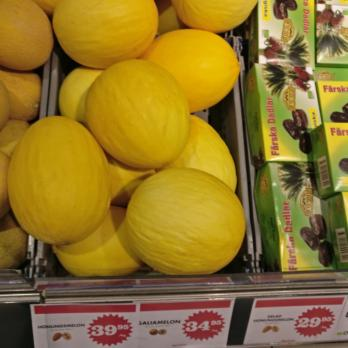

  - Passion-Fruit_016.jpg



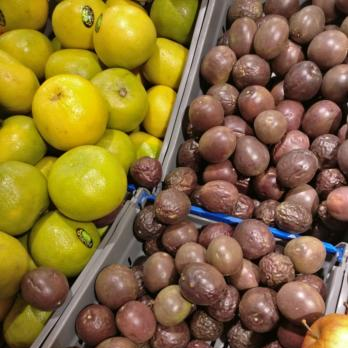

In [14]:
string question = "lisbon dessert";

float[] queryVector = await _aiVisionHelper.GetTextEmbedding(question);

Console.WriteLine("vector:" + queryVector);

//Cognitive Search - Query Search Index
List<ImageEmbedding> results = await _aiVisionHelper.QuerySearchIndex(searchIndexName, queryVector);
Console.WriteLine($"Cognitive Search Results for '{question}':");
foreach(ImageEmbedding result in results)
{
    Console.WriteLine($"  - {result.title}");
    var imageUrl = await _aiVisionHelper.GetBlobSharedUrl(result.metadata_storage_path);
    await SkiaUtils.ShowImage(imageUrl.ToString(), 348, 348);
}



The architecture sketch: 

![Embeddings](./img/Embeddings.png) 

is provided as top search result. Notice that in the sketch nowhere the phrase "Vector" is used. The MLLM conserved the semantic meaning of the architecture sketch and Embedding can be translated to Vector. Therefore the Azure AI Search instance provided it as result with the closest distance.
